In [1]:
import pandas as pd
import numpy as np
import texthero as hero

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk import PorterStemmer, LancasterStemmer, SnowballStemmer
pd.set_option('display.max_columns', None)

# Overview features

In [2]:
dft=pd.read_csv('movie_variable_full.csv')
dft
dft.columns

Index(['id', 'tconst', 'titleType', 'primaryTitle', 'originalTitle',
       'startYear', 'release_date', 'isAdult', 'genres', 'runtime', 'budget',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'revenue', 'status',
       'vote_average', 'vote_count', 'averageRating', 'numVotes', 'director',
       'actor'],
      dtype='object')

In [3]:
df=dft[['overview','averageRating']]
df

overview  averageRating
0      The first woman to appear in front of an Ediso...            5.6
1      One night, Arlequin come to see his lover Colo...            6.5
2      Three men hammer on an anvil and pass a bottle...            6.1
3      A man (Thomas Edison's assistant) takes a pinc...            5.4
4      Working men and women leave the Lumière factor...            6.9
...                                                  ...            ...
45302  Unbridled comic Chris D'Elia reconsiders his a...            6.5
45303  Stranded in an Arctic mine, two survivors are ...            7.3
45304  Set during the Vietnam war, Firebase follows A...            7.2
45305  William Shatner sits down with scientists, inn...            6.7
45306  When Supergirl, Wonder Woman, Batgirl, Bumbleb...            5.2

[45307 rows x 2 columns]

In [5]:
preprocess_pipeline = [hero.preprocessing.lowercase,
                       hero.preprocessing.remove_digits,
                       hero.preprocessing.remove_urls,
                       hero.preprocessing.remove_punctuation,  #reserve punctuation
                       hero.preprocessing.remove_stopwords,
                       hero.preprocessing.remove_urls,
                       hero.preprocessing.remove_html_tags,
                       
                       ]

df['clean_overview'] = df['overview'].pipe(hero.clean, preprocess_pipeline)

<ipython-input-5-5c1e3da8dfec>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_overview'] = df['overview'].pipe(hero.clean, preprocess_pipeline)


In [6]:
from sklearn import set_config
set_config(display='diagram')

preprocess_pipeline

[<function texthero.preprocessing.lowercase(input: pandas.core.series.Series) -> pandas.core.series.Series>,
 <function texthero.preprocessing.remove_digits(input: pandas.core.series.Series, only_blocks=True) -> pandas.core.series.Series>,
 <function texthero.preprocessing.remove_urls(s: pandas.core.series.Series) -> pandas.core.series.Series>,
 <function texthero.preprocessing.remove_punctuation(input: pandas.core.series.Series) -> pandas.core.series.Series>,
 <function texthero.preprocessing.remove_stopwords(input: pandas.core.series.Series, stopwords: Union[Set[str], NoneType] = None, remove_str_numbers=False) -> pandas.core.series.Series>,
 <function texthero.preprocessing.remove_urls(s: pandas.core.series.Series) -> pandas.core.series.Series>,
 <function texthero.preprocessing.remove_html_tags(s: pandas.core.series.Series) -> pandas.core.series.Series>]

In [23]:
# Function to apply lemmatization
def words_lemmatizer(text, encoding="utf8"):
    words = nltk.word_tokenize(text)
    lemma_words = []
    wl = WordNetLemmatizer()
    for word in words:
        pos = find_pos(word)
        lemma_words.append(wl.lemmatize(word, pos))
    return " ".join(lemma_words)

def find_pos(word):
    # Part of Speech constants
    # ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
    pos = nltk.pos_tag(nltk.word_tokenize(word))[0][1]   
    # Adjective tags - 'JJ', 'JJR', 'JJS'
    if pos.lower()[0] == 'j':
        return 'a'
    # Adverb tags - 'RB', 'RBR', 'RBS'
    elif pos.lower()[0] == 'r':
        return 'r'
    # Verb tags - 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
    elif pos.lower()[0] == 'v':
        return 'v'
    # Noun tags - 'NN', 'NNS', 'NNP', 'NNPS'
    else:
        return 'n'

In [29]:
df['clean_overview'] = df['clean_overview'].apply(lambda x: words_lemmatizer(x))
df['clean_overview'] = df['clean_overview'].apply(lambda x: hero.preprocessing.fillna(pd.Series(x))) # Found some na because those comments only contain web link.
df['clean_overview'] = df['clean_overview'].apply(lambda x: LancasterStemmer().stem(x)) # Apply stemming

In [ ]:
df.to_csv('clean_overview')

## BOW

In [5]:
import numpy as np
from nltk.corpus import stopwords

#Tokenize a sentence
def word_extraction(sentence):
    words = sentence.split()
    stop_words = set(stopwords.words('english'))
    cleaned_text = [w.lower() for w in words if not w in stop_words]
    return cleaned_text

#Apply tokenization to all sentences
def tokenize(sentences):
    words = []
    for sentence in sentences:
        w = word_extraction(sentence)
        words.extend(w)
    words = sorted(list(set(words)))
    return words

#Build vocabulary and generate vectors
def generate_bow(allsentences):
    bow_vector = []
    vocab = tokenize(allsentences)
    # print("Word List for Document \n{0} \n".format(vocab))
    for sentence in allsentences:
        words = word_extraction(sentence)
        bag_vector = np.zeros(len(vocab))
        for w in words:
            for i, word in enumerate(vocab):
                if word == w:
                    bag_vector[i] += 1
        bag_vector=bag_vector.tolist()
        bow_vector.append(bag_vector)
        # print("{0}\n{1}\n".format(sentence, np.array(bag_vector)))
        
    return vocab, bow_vector 


In [ ]:
overview_list=[]
for i in range(len(df)):
    overview_list.append(df.loc[i,'overview'])

In [2]:
print(generate_bow(overview_list)) #

In [ ]:
import numpy as np
def getLength(df):
    df["length"]=np.nan
    for i in range(len(df["overview"])):
        df["length"][i] = len(df["overview"][i])
    return df

df = getLength(df)

<ipython-input-17-98326117f74e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["length"]=np.nan
<ipython-input-17-98326117f74e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["length"][i] = len(df["overview"][i])
<ipython-input-17-98326117f74e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df = getLength(df)


In [ ]:
df['length'].sum()/len(df)

316.8495375990465

Too many features for overview, so turn to key words instead

# key words features

In [4]:
import pandas as pd
from wordcloud import WordCloud
from ast import literal_eval
import matplotlib.pyplot as plt
df_key=pd.read_csv('keywords.csv')
df_key
df_key['keywords'] = df_key['keywords'].apply(literal_eval)
df_key

id                                           keywords
0         862  [{'id': 931, 'name': 'jealousy'}, {'id': 4290,...
1        8844  [{'id': 10090, 'name': 'board game'}, {'id': 1...
2       15602  [{'id': 1495, 'name': 'fishing'}, {'id': 12392...
3       31357  [{'id': 818, 'name': 'based on novel'}, {'id':...
4       11862  [{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...
...       ...                                                ...
46414  439050             [{'id': 10703, 'name': 'tragic love'}]
46415  111109  [{'id': 2679, 'name': 'artist'}, {'id': 14531,...
46416   67758                                                 []
46417  227506                                                 []
46418  461257                                                 []

[46419 rows x 2 columns]

In [5]:
df_key['keywords'] = df_key['keywords'].apply(lambda x: [ i['name'] for i in x] if isinstance(x,list) else [])

def listtostr(txt):
    txt_clean = ' '.join([str(elem) for elem in txt])
    return txt_clean

df_key['keywords'] = df_key['keywords'].apply(listtostr)
df_key

id                                           keywords
0         862  jealousy toy boy friendship friends rivalry bo...
1        8844  board game disappearance based on children's b...
2       15602   fishing best friend duringcreditsstinger old men
3       31357  based on novel interracial relationship single...
4       11862  baby midlife crisis confidence aging daughter ...
...       ...                                                ...
46414  439050                                        tragic love
46415  111109                                  artist play pinoy
46416   67758                                                   
46417  227506                                                   
46418  461257                                                   

[46419 rows x 2 columns]

In [6]:
df_merge = pd.merge(dft, df_key, on=['id'])
df_key=df_merge[['id','keywords','averageRating']]
df_key=df_key.drop(df_key[df_key.keywords==''].index)
df_key=df_key.reset_index(drop=True)
df_key

id                                           keywords  \
0       16612                                 dancer silent film   
1       88013                                              short   
2       16624                            blacksmith beer workmen   
3         774  factory worker factory lyon closing time film ...   
4         160  france train station cinema beginning film and...   
...       ...                                                ...   
31568  461634                                    stand-up comedy   
31569  462108                                    stand-up comedy   
31570  463800                                  vietnam war short   
31571  464207                      nature science canadian movie   
31572  460135                                     superhero lego   

       averageRating  
0                5.6  
1                6.5  
2                6.1  
3                6.9  
4                7.4  
...              ...  
31568            6.8  
31569            6.5  
31570            7.2  
31571            6.7  
31572            5.2  

[31573 rows x 3 columns]

In [7]:
preprocess_pipeline = [hero.preprocessing.lowercase,
                       hero.preprocessing.remove_digits,
                       hero.preprocessing.remove_urls,
                       hero.preprocessing.remove_punctuation,  #reserve punctuation
                       hero.preprocessing.remove_stopwords,
                       hero.preprocessing.remove_urls,
                       hero.preprocessing.remove_html_tags,
                       
                       ]

df_key['clean_key'] = df_key['keywords'].pipe(hero.clean, preprocess_pipeline)
df_key

id                                           keywords  \
0       16612                                 dancer silent film   
1       88013                                              short   
2       16624                            blacksmith beer workmen   
3         774  factory worker factory lyon closing time film ...   
4         160  france train station cinema beginning film and...   
...       ...                                                ...   
31568  461634                                    stand-up comedy   
31569  462108                                    stand-up comedy   
31570  463800                                  vietnam war short   
31571  464207                      nature science canadian movie   
31572  460135                                     superhero lego   

       averageRating                                          clean_key  
0                5.6                                 dancer silent film  
1                6.5                                              short  
2                6.1                            blacksmith beer workmen  
3                6.9  factory worker factory lyon closing time film ...  
4                7.4  france train station cinema beginning film  ci...  
...              ...                                                ...  
31568            6.8                                      stand  comedy  
31569            6.5                                      stand  comedy  
31570            7.2                                  vietnam war short  
31571            6.7                      nature science canadian movie  
31572            5.2                                     superhero lego  

[31573 rows x 4 columns]

In [8]:
# Function to apply lemmatization
def words_lemmatizer(text, encoding="utf8"):
    words = nltk.word_tokenize(text)
    lemma_words = []
    wl = WordNetLemmatizer()
    for word in words:
        pos = find_pos(word)
        lemma_words.append(wl.lemmatize(word, pos))
    return " ".join(lemma_words)

def find_pos(word):
    # Part of Speech constants
    # ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
    pos = nltk.pos_tag(nltk.word_tokenize(word))[0][1]   
    # Adjective tags - 'JJ', 'JJR', 'JJS'
    if pos.lower()[0] == 'j':
        return 'a'
    # Adverb tags - 'RB', 'RBR', 'RBS'
    elif pos.lower()[0] == 'r':
        return 'r'
    # Verb tags - 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
    elif pos.lower()[0] == 'v':
        return 'v'
    # Noun tags - 'NN', 'NNS', 'NNP', 'NNPS'
    else:
        return 'n'

In [10]:
df_key['clean_key'] = df_key['clean_key'].apply(lambda x: words_lemmatizer(x))
df_key['clean_key'] = df_key['clean_key'].apply(lambda x: hero.preprocessing.fillna(pd.Series(x))) # Found some na because those comments only contain web link.
df_key['clean_key'] = df_key['clean_key'].apply(lambda x: LancasterStemmer().stem(x)) # Apply stemming

In [13]:
df_key.to_csv('clean_key.csv')

In [7]:
df_key=pd.read_csv('clean_key.csv')
df_key=df_key.drop(columns={'Unnamed: 0'})
df_key

id                                           keywords  \
0       16612                                 dancer silent film   
1       88013                                              short   
2       16624                            blacksmith beer workmen   
3         774  factory worker factory lyon closing time film ...   
4         160  france train station cinema beginning film and...   
...       ...                                                ...   
31568  461634                                    stand-up comedy   
31569  462108                                    stand-up comedy   
31570  463800                                  vietnam war short   
31571  464207                      nature science canadian movie   
31572  460135                                     superhero lego   

       averageRating                                          clean_key  
0                5.6                                 dancer silent film  
1                6.5                                              short  
2                6.1                            blacksmith beer workman  
3                6.9  factory worker factory lyon closing time film ...  
4                7.4  france train station cinema begin film cinema ...  
...              ...                                                ...  
31568            6.8                                       stand comedy  
31569            6.5                                       stand comedy  
31570            7.2                                  vietnam war short  
31571            6.7                       nature science canadian movi  
31572            5.2                                     superhero lego  

[31573 rows x 4 columns]

# BOW

In [16]:
# df_key=pd.read_csv('clean_key.csv')
keywords_list=[]
for i in range(len(df_key)):
    keywords_list.append(str(df_key.loc[i,'clean_key']))

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=10,stop_words='english')
vect.fit(keywords_list) 
X = vect.transform(keywords_list)  

X 

<31573x2953 sparse matrix of type '<class 'numpy.int64'>'
	with 188090 stored elements in Compressed Sparse Row format>

In [16]:
vectdf=pd.DataFrame(X.toarray())

In [17]:
word = vect.get_feature_names() 
vectdf.columns=word
vectdf

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


16th  17th  18th  1910s  1920s  1930s  1940s  1950s  1960s  1970s  \
0         0     0     0      0      0      0      0      0      0      0   
1         0     0     0      0      0      0      0      0      0      0   
2         0     0     0      0      0      0      0      0      0      0   
3         0     0     0      0      0      0      0      0      0      0   
4         0     0     0      0      0      0      0      0      0      0   
...     ...   ...   ...    ...    ...    ...    ...    ...    ...    ...   
31568     0     0     0      0      0      0      0      0      0      0   
31569     0     0     0      0      0      0      0      0      0      0   
31570     0     0     0      0      0      0      0      0      0      0   
31571     0     0     0      0      0      0      0      0      0      0   
31572     0     0     0      0      0      0      0      0      0      0   

       1980s  1990s  19th  20th  3d  70  abandon  abandonment  abduction  \
0          0      0     0     0   0   0        0            0          0   
1          0      0     0     0   0   0        0            0          0   
2          0      0     0     0   0   0        0            0          0   
3          0      0     0     0   0   0        0            0          0   
4          0      0     0     0   0   0        0            0          0   
...      ...    ...   ...   ...  ..  ..      ...          ...        ...   
31568      0      0     0     0   0   0        0            0          0   
31569      0      0     0     0   0   0        0            0          0   
31570      0      0     0     0   0   0        0            0          0   
31571      0      0     0     0   0   0        0            0          0   
31572      0      0     0     0   0   0        0            0          0   

       abortion  abroad  abus  abuse  abusive  academy  accident  accusation  \
0             0       0     0      0        0        0         0           0   
1             0       0     0      0        0        0         0           0   
2             0       0     0      0        0        0         0           0   
3             0       0     0      0        0        0         0           0   
4             0       0     0      0        0        0         0           0   
...         ...     ...   ...    ...      ...      ...       ...         ...   
31568         0       0     0      0        0        0         0           0   
31569         0       0     0      0        0        0         0           0   
31570         0       0     0      0        0        0         0           0   
31571         0       0     0      0        0        0         0           0   
31572         0       0     0      0        0        0         0           0   

       accuse  act  action  activism  activist  actor  actress  ad  \
0           0    0       0         0         0      0        0   0   
1           0    0       0         0         0      0        0   0   
2           0    0       0         0         0      0        0   0   
3           0    0       0         0         0      0        0   0   
4           0    0       0         0         0      0        0   0   
...       ...  ...     ...       ...       ...    ...      ...  ..   
31568       0    0       0         0         0      0        0   0   
31569       0    0       0         0         0      0        0   0   
31570       0    0       0         0         0      0        0   0   
31571       0    0       0         0         0      0        0   0   
31572       0    0       0         0         0      0        0   0   

       adaptation  addict  addiction  adolescence  adolf  adopt  adoption  \
0               0       0          0            0      0      0         0   
1               0       0          0            0      0      0         0   
2               0       0          0            0      0      0         0   
3               0       0          0            0      0      0        

In [29]:
total_vect=pd.concat([df_key,vectdf],axis=1)
total_vect.to_csv('5153_CountVectorizer_features.csv')

In [18]:
labels = df_key.averageRating.tolist()
w=0
z=0
for i in range(len(labels)):
  if labels[i]>=6.5:
    labels[i]=1
    w+=1
  else:
    labels[i]=0
    z+=1


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

x_train,x_test,y_train,y_test=train_test_split(vectdf,labels,test_size=0.3)
lr_clf = LogisticRegression(max_iter=20000)
lr_clf.fit(x_train, y_train)

#validate the model
lr_clf.score(x_test, y_test)

0.6329180743243243

In [21]:
vectcoef=lr_clf.coef_.tolist()[0]
vectsorted_id_pos = sorted(range(len(vectcoef)), key=lambda k: vectcoef[k], reverse=True)
vectsorted_id_pos

[114,
 1116,
 262,
 1345,
 1409,
 2807,
 894,
 2279,
 1314,
 520,
 569,
 1679,
 1216,
 2936,
 2148,
 1943,
 1029,
 2783,
 294,
 491,
 2175,
 2698,
 2934,
 2298,
 231,
 1382,
 109,
 1692,
 1999,
 1614,
 282,
 2432,
 2753,
 1775,
 583,
 2314,
 2888,
 2571,
 2195,
 2515,
 2103,
 2504,
 511,
 1189,
 2430,
 2381,
 2168,
 2222,
 390,
 858,
 68,
 7,
 1861,
 10,
 2946,
 2238,
 475,
 1733,
 1764,
 628,
 959,
 2872,
 1251,
 551,
 199,
 2601,
 565,
 1609,
 248,
 2127,
 1642,
 1141,
 2266,
 1193,
 468,
 1185,
 196,
 2548,
 758,
 2112,
 117,
 1915,
 2323,
 195,
 741,
 781,
 2621,
 1804,
 2069,
 140,
 536,
 1680,
 182,
 2777,
 1919,
 2776,
 1813,
 2041,
 727,
 1591,
 1124,
 507,
 1236,
 510,
 206,
 1502,
 2848,
 1128,
 342,
 2945,
 86,
 1024,
 387,
 2351,
 423,
 376,
 1585,
 2219,
 2856,
 2871,
 982,
 2779,
 1582,
 2867,
 2388,
 147,
 133,
 101,
 863,
 23,
 2313,
 400,
 1771,
 1077,
 2110,
 2620,
 931,
 1290,
 927,
 627,
 362,
 160,
 2081,
 559,
 2524,
 578,
 591,
 184,
 429,
 9,
 418,
 1542,
 801,


In [39]:
for i in range(5):
    print(vectdf.columns.tolist()[vectsorted_id_pos[i]])


anime
gojira
bell
innocence
jazz


In [40]:
vectsorted_id_neg = sorted(range(len(vectcoef)), key=lambda k: vectcoef[k], reverse=False)
vectsorted_id_neg

[435,
 272,
 1449,
 276,
 826,
 2356,
 2883,
 136,
 2423,
 1992,
 230,
 1169,
 2949,
 1841,
 46,
 241,
 444,
 2841,
 2261,
 2681,
 1354,
 1753,
 1783,
 899,
 2828,
 990,
 269,
 1457,
 2302,
 2194,
 2535,
 2096,
 1740,
 509,
 2543,
 2461,
 903,
 2106,
 916,
 1173,
 296,
 1403,
 1604,
 2868,
 414,
 2122,
 2638,
 2903,
 408,
 2880,
 530,
 2581,
 245,
 862,
 2216,
 1671,
 2067,
 171,
 2822,
 1190,
 2927,
 579,
 2173,
 366,
 204,
 2745,
 1886,
 1373,
 1300,
 940,
 2172,
 2185,
 2047,
 1938,
 1198,
 1832,
 1197,
 759,
 275,
 310,
 1335,
 2452,
 2691,
 2724,
 2658,
 159,
 1587,
 785,
 1040,
 1720,
 219,
 2248,
 746,
 1094,
 1026,
 535,
 371,
 816,
 1939,
 2669,
 666,
 661,
 1927,
 1339,
 2832,
 2340,
 2038,
 1641,
 2586,
 2687,
 2474,
 704,
 2431,
 1781,
 1050,
 844,
 1866,
 2424,
 2948,
 295,
 1155,
 1025,
 776,
 1464,
 1440,
 1530,
 1557,
 1590,
 471,
 938,
 1801,
 1259,
 965,
 554,
 883,
 1552,
 548,
 2213,
 323,
 2808,
 2618,
 1021,
 2538,
 1615,
 1038,
 2935,
 1012,
 336,
 2005,
 2670,
 

In [41]:
for i in range(5):
    print(vectdf.columns.tolist()[vectsorted_id_neg[i]])

carry
bigfoot
karate
bikini
duringcreditssting


# One Hot Encoding

In [42]:
bowdf=pd.read_csv('keywords_CountVectorizer_features.csv')

In [43]:
bowdf=bowdf.drop(columns={'Unnamed: 0','id','keywords','averageRating','clean_key'})
bowdf

16th  17th  18th  1910s  1920s  1930s  1940s  1950s  1960s  1970s  \
0         0     0     0      0      0      0      0      0      0      0   
1         0     0     0      0      0      0      0      0      0      0   
2         0     0     0      0      0      0      0      0      0      0   
3         0     0     0      0      0      0      0      0      0      0   
4         0     0     0      0      0      0      0      0      0      0   
...     ...   ...   ...    ...    ...    ...    ...    ...    ...    ...   
31568     0     0     0      0      0      0      0      0      0      0   
31569     0     0     0      0      0      0      0      0      0      0   
31570     0     0     0      0      0      0      0      0      0      0   
31571     0     0     0      0      0      0      0      0      0      0   
31572     0     0     0      0      0      0      0      0      0      0   

       1980s  1990s  19th  20th  3d  70  abandon  abandonment  abduction  \
0          0      0     0     0   0   0        0            0          0   
1          0      0     0     0   0   0        0            0          0   
2          0      0     0     0   0   0        0            0          0   
3          0      0     0     0   0   0        0            0          0   
4          0      0     0     0   0   0        0            0          0   
...      ...    ...   ...   ...  ..  ..      ...          ...        ...   
31568      0      0     0     0   0   0        0            0          0   
31569      0      0     0     0   0   0        0            0          0   
31570      0      0     0     0   0   0        0            0          0   
31571      0      0     0     0   0   0        0            0          0   
31572      0      0     0     0   0   0        0            0          0   

       abortion  abroad  abus  abuse  abusive  academy  accident  accusation  \
0             0       0     0      0        0        0         0           0   
1             0       0     0      0        0        0         0           0   
2             0       0     0      0        0        0         0           0   
3             0       0     0      0        0        0         0           0   
4             0       0     0      0        0        0         0           0   
...         ...     ...   ...    ...      ...      ...       ...         ...   
31568         0       0     0      0        0        0         0           0   
31569         0       0     0      0        0        0         0           0   
31570         0       0     0      0        0        0         0           0   
31571         0       0     0      0        0        0         0           0   
31572         0       0     0      0        0        0         0           0   

       accuse  act  action  activism  activist  actor  actress  ad  \
0           0    0       0         0         0      0        0   0   
1           0    0       0         0         0      0        0   0   
2           0    0       0         0         0      0        0   0   
3           0    0       0         0         0      0        0   0   
4           0    0       0         0         0      0        0   0   
...       ...  ...     ...       ...       ...    ...      ...  ..   
31568       0    0       0         0         0      0        0   0   
31569       0    0       0         0         0      0        0   0   
31570       0    0       0         0         0      0        0   0   
31571       0    0       0         0         0      0        0   0   
31572       0    0       0         0         0      0        0   0   

       adaptation  addict  addiction  adolescence  adolf  adopt  adoption  \
0               0       0          0            0      0      0         0   
1               0       0          0            0      0      0         0   
2               0       0          0            0      0      0         0   
3               0       0          0            0      0      0        

In [45]:
for i in range(len(bowdf)):
    for j in range(len(bowdf.columns.tolist())):
        if bowdf.iloc[i,j]>=1:
            bowdf.iloc[i,j]=1
        

In [38]:
total_bow=pd.concat([df_key,bowdf],axis=1)
total_bow=total_bow.drop(columns={'Unnamed: 0'})
total_bow

id                                           keywords  \
0       16612                                 dancer silent film   
1       88013                                              short   
2       16624                            blacksmith beer workmen   
3         774  factory worker factory lyon closing time film ...   
4         160  france train station cinema beginning film and...   
...       ...                                                ...   
31568  461634                                    stand-up comedy   
31569  462108                                    stand-up comedy   
31570  463800                                  vietnam war short   
31571  464207                      nature science canadian movie   
31572  460135                                     superhero lego   

       averageRating                                          clean_key  16th  \
0                5.6                                 dancer silent film     0   
1                6.5                                              short     0   
2                6.1                            blacksmith beer workman     0   
3                6.9  factory worker factory lyon closing time film ...     0   
4                7.4  france train station cinema begin film cinema ...     0   
...              ...                                                ...   ...   
31568            6.8                                       stand comedy     0   
31569            6.5                                       stand comedy     0   
31570            7.2                                  vietnam war short     0   
31571            6.7                       nature science canadian movi     0   
31572            5.2                                     superhero lego     0   

       17th  18th  1910s  1920s  1930s  1940s  1950s  1960s  1970s  1980s  \
0         0     0      0      0      0      0      0      0      0      0   
1         0     0      0      0      0      0      0      0      0      0   
2         0     0      0      0      0      0      0      0      0      0   
3         0     0      0      0      0      0      0      0      0      0   
4         0     0      0      0      0      0      0      0      0      0   
...     ...   ...    ...    ...    ...    ...    ...    ...    ...    ...   
31568     0     0      0      0      0      0      0      0      0      0   
31569     0     0      0      0      0      0      0      0      0      0   
31570     0     0      0      0      0      0      0      0      0      0   
31571     0     0      0      0      0      0      0      0      0      0   
31572     0     0      0      0      0      0      0      0      0      0   

       1990s  19th  20th  3d  70  abandon  abandonment  abduction  abortion  \
0          0     0     0   0   0        0            0          0         0   
1          0     0     0   0   0        0            0          0         0   
2          0     0     0   0   0        0            0          0         0   
3          0     0     0   0   0        0            0          0         0   
4          0     0     0   0   0        0            0          0         0   
...      ...   ...   ...  ..  ..      ...          ...        ...       ...   
31568      0     0     0   0   0        0            0          0         0   
31569      0     0     0   0   0        0            0          0         0   
31570      0     0     0   0   0        0            0          0         0   
31571      0     0     0   0   0        0            0          0         0   
31572      0     0     0   0   0        0            0          0         0   

       abroad  abus  abuse  abusive  academy  accident  accusation  accuse  \
0           0     0      0        0        0         0           0       0   
1           0     0      0        0        0         0           0       0   
2           0     0      0        0        0         0           0       0   
3           0     0      0        0

In [39]:
total_bow.to_csv('keywords_BOW_features.csv')

In [46]:
bowdf=pd.read_csv('keywords_BOW_features.csv')

In [49]:
bowdf=bowdf.drop(columns={'Unnamed: 0','id','keywords','averageRating', 'clean_key'})

In [50]:
bowdf

16th  17th  18th  1910s  1920s  1930s  1940s  1950s  1960s  1970s  \
0         0     0     0      0      0      0      0      0      0      0   
1         0     0     0      0      0      0      0      0      0      0   
2         0     0     0      0      0      0      0      0      0      0   
3         0     0     0      0      0      0      0      0      0      0   
4         0     0     0      0      0      0      0      0      0      0   
...     ...   ...   ...    ...    ...    ...    ...    ...    ...    ...   
31568     0     0     0      0      0      0      0      0      0      0   
31569     0     0     0      0      0      0      0      0      0      0   
31570     0     0     0      0      0      0      0      0      0      0   
31571     0     0     0      0      0      0      0      0      0      0   
31572     0     0     0      0      0      0      0      0      0      0   

       1980s  1990s  19th  20th  3d  70  abandon  abandonment  abduction  \
0          0      0     0     0   0   0        0            0          0   
1          0      0     0     0   0   0        0            0          0   
2          0      0     0     0   0   0        0            0          0   
3          0      0     0     0   0   0        0            0          0   
4          0      0     0     0   0   0        0            0          0   
...      ...    ...   ...   ...  ..  ..      ...          ...        ...   
31568      0      0     0     0   0   0        0            0          0   
31569      0      0     0     0   0   0        0            0          0   
31570      0      0     0     0   0   0        0            0          0   
31571      0      0     0     0   0   0        0            0          0   
31572      0      0     0     0   0   0        0            0          0   

       abortion  abroad  abus  abuse  abusive  academy  accident  accusation  \
0             0       0     0      0        0        0         0           0   
1             0       0     0      0        0        0         0           0   
2             0       0     0      0        0        0         0           0   
3             0       0     0      0        0        0         0           0   
4             0       0     0      0        0        0         0           0   
...         ...     ...   ...    ...      ...      ...       ...         ...   
31568         0       0     0      0        0        0         0           0   
31569         0       0     0      0        0        0         0           0   
31570         0       0     0      0        0        0         0           0   
31571         0       0     0      0        0        0         0           0   
31572         0       0     0      0        0        0         0           0   

       accuse  act  action  activism  activist  actor  actress  ad  \
0           0    0       0         0         0      0        0   0   
1           0    0       0         0         0      0        0   0   
2           0    0       0         0         0      0        0   0   
3           0    0       0         0         0      0        0   0   
4           0    0       0         0         0      0        0   0   
...       ...  ...     ...       ...       ...    ...      ...  ..   
31568       0    0       0         0         0      0        0   0   
31569       0    0       0         0         0      0        0   0   
31570       0    0       0         0         0      0        0   0   
31571       0    0       0         0         0      0        0   0   
31572       0    0       0         0         0      0        0   0   

       adaptation  addict  addiction  adolescence  adolf  adopt  adoption  \
0               0       0          0            0      0      0         0   
1               0       0          0            0      0      0         0   
2               0       0          0            0      0      0         0   
3               0       0          0            0      0      0        

In [51]:
labels = df_key.averageRating.tolist()
w=0
z=0
for i in range(len(labels)):
  if labels[i]>=6.5:
    labels[i]=1
    w+=1
  else:
    labels[i]=0
    z+=1

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

x_train,x_test,y_train,y_test=train_test_split(bowdf,labels,test_size=0.3)
lr_clf = LogisticRegression(max_iter=20000)
lr_clf.fit(x_train, y_train)

#validate the model
lr_clf.score(x_test, y_test)

0.6342905405405406

In [54]:
bowcoef=lr_clf.coef_.tolist()[0]
bowsorted_id_pos = sorted(range(len(bowcoef)), key=lambda k: bowcoef[k], reverse=True)
bowsorted_id_pos

[511,
 2279,
 1943,
 114,
 520,
 2571,
 2807,
 2432,
 2783,
 362,
 2222,
 1116,
 2195,
 1290,
 894,
 2314,
 231,
 1345,
 1727,
 140,
 2298,
 390,
 1591,
 1614,
 7,
 1775,
 1852,
 1381,
 2601,
 109,
 2219,
 2943,
 1251,
 1312,
 1804,
 808,
 2430,
 628,
 2041,
 1314,
 1679,
 279,
 2504,
 1193,
 1216,
 2381,
 2863,
 951,
 2313,
 175,
 282,
 525,
 1574,
 1382,
 1342,
 2238,
 846,
 659,
 2639,
 2080,
 959,
 2872,
 1680,
 510,
 491,
 727,
 858,
 720,
 507,
 927,
 31,
 2946,
 1811,
 2082,
 63,
 1999,
 1861,
 2206,
 1585,
 248,
 2333,
 2694,
 2591,
 339,
 2515,
 551,
 2131,
 1288,
 1792,
 989,
 68,
 1334,
 2517,
 315,
 917,
 781,
 1307,
 1582,
 382,
 359,
 1785,
 822,
 1018,
 2110,
 418,
 2579,
 2936,
 1204,
 559,
 1547,
 1408,
 1813,
 189,
 2097,
 970,
 73,
 2621,
 2349,
 1619,
 2620,
 102,
 2856,
 2127,
 1915,
 298,
 1962,
 1237,
 2945,
 2081,
 1881,
 2933,
 2917,
 2524,
 2316,
 521,
 2871,
 1692,
 2867,
 2671,
 2341,
 1725,
 86,
 820,
 198,
 37,
 364,
 2188,
 2170,
 2580,
 10,
 801,
 475,
 

In [55]:
for i in range(5):
    print(bowdf.columns.tolist()[bowsorted_id_pos[i]])


cinematic
samurai
phenomenon
anime
classic


In [57]:
bowsorted_id_neg = sorted(range(len(bowcoef)), key=lambda k: bowcoef[k], reverse=False)
bowsorted_id_neg

[903,
 241,
 276,
 1992,
 2949,
 746,
 1173,
 2423,
 940,
 2248,
 1684,
 435,
 2172,
 136,
 244,
 2356,
 2927,
 296,
 2142,
 2877,
 2832,
 1457,
 1259,
 2185,
 46,
 275,
 1924,
 990,
 2096,
 2261,
 1440,
 1300,
 2521,
 1449,
 2669,
 2880,
 2164,
 1403,
 973,
 2194,
 759,
 2642,
 2828,
 408,
 1762,
 1354,
 2687,
 844,
 2681,
 1841,
 1135,
 2302,
 965,
 899,
 2948,
 579,
 2089,
 2572,
 1094,
 1025,
 2503,
 1989,
 548,
 1939,
 272,
 523,
 2808,
 1633,
 2235,
 371,
 538,
 444,
 2903,
 816,
 230,
 2764,
 1530,
 791,
 2141,
 1567,
 2364,
 785,
 2036,
 2233,
 516,
 2173,
 366,
 911,
 1823,
 2440,
 2216,
 776,
 1824,
 2011,
 2401,
 2733,
 421,
 2535,
 1876,
 171,
 2658,
 1912,
 1641,
 1801,
 1756,
 303,
 509,
 204,
 1324,
 2001,
 2464,
 2600,
 1155,
 277,
 16,
 883,
 210,
 553,
 2729,
 1239,
 826,
 212,
 2258,
 1862,
 1765,
 1866,
 2841,
 1845,
 1753,
 226,
 999,
 2067,
 1337,
 2480,
 471,
 2801,
 498,
 265,
 1335,
 2018,
 1608,
 2145,
 1831,
 1197,
 2516,
 2443,
 2921,
 1519,
 747,
 987,
 274

In [58]:
for i in range(5):
    print(bowdf.columns.tolist()[bowsorted_id_neg[i]])


escort
bat
bikini
pokémon
zomby


# TF-IDF

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.feature_extraction.text import CountVectorizer  

vectorizer = CountVectorizer(min_df=10,stop_words='english')

X = vectorizer.fit_transform(keywords_list)  

word = vectorizer.get_feature_names()  

transformer = TfidfTransformer()  
tfidf = transformer.fit_transform(X)  

df_tfidf = pd.DataFrame(tfidf.toarray())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [60]:
df_tfidf.columns=word
total_tfidf=pd.concat([df_key,df_tfidf],axis=1)
total_tfidf=total_tfidf.drop(columns={'Unnamed: 0'})
total_tfidf

In [22]:
total_tfidf.to_csv('keywords_TFIDF_features.csv')


In [11]:
# df_tfidf=pd.read_csv('keywords_TFIDF_features.csv')
df_tfidf=df_tfidf.drop(columns={'Unnamed: 0','id','keywords','averageRating','clean_key'})
df_tfidf

16th  17th  18th  1910s  1920s  1930s  1940s  1950s  1960s  1970s  \
0       0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1       0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2       0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3       0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4       0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...     ...   ...   ...    ...    ...    ...    ...    ...    ...    ...   
31568   0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
31569   0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
31570   0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
31571   0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
31572   0.0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

       1980s  1990s  19th  20th   3d   70  abandon  abandonment  abduction  \
0        0.0    0.0   0.0   0.0  0.0  0.0      0.0          0.0        0.0   
1        0.0    0.0   0.0   0.0  0.0  0.0      0.0          0.0        0.0   
2        0.0    0.0   0.0   0.0  0.0  0.0      0.0          0.0        0.0   
3        0.0    0.0   0.0   0.0  0.0  0.0      0.0          0.0        0.0   
4        0.0    0.0   0.0   0.0  0.0  0.0      0.0          0.0        0.0   
...      ...    ...   ...   ...  ...  ...      ...          ...        ...   
31568    0.0    0.0   0.0   0.0  0.0  0.0      0.0          0.0        0.0   
31569    0.0    0.0   0.0   0.0  0.0  0.0      0.0          0.0        0.0   
31570    0.0    0.0   0.0   0.0  0.0  0.0      0.0          0.0        0.0   
31571    0.0    0.0   0.0   0.0  0.0  0.0      0.0          0.0        0.0   
31572    0.0    0.0   0.0   0.0  0.0  0.0      0.0          0.0        0.0   

       abortion  abroad  abus  abuse  abusive  academy  accident  accusation  \
0           0.0     0.0   0.0    0.0      0.0      0.0       0.0         0.0   
1           0.0     0.0   0.0    0.0      0.0      0.0       0.0         0.0   
2           0.0     0.0   0.0    0.0      0.0      0.0       0.0         0.0   
3           0.0     0.0   0.0    0.0      0.0      0.0       0.0         0.0   
4           0.0     0.0   0.0    0.0      0.0      0.0       0.0         0.0   
...         ...     ...   ...    ...      ...      ...       ...         ...   
31568       0.0     0.0   0.0    0.0      0.0      0.0       0.0         0.0   
31569       0.0     0.0   0.0    0.0      0.0      0.0       0.0         0.0   
31570       0.0     0.0   0.0    0.0      0.0      0.0       0.0         0.0   
31571       0.0     0.0   0.0    0.0      0.0      0.0       0.0         0.0   
31572       0.0     0.0   0.0    0.0      0.0      0.0       0.0         0.0   

       accuse  act  action  activism  activist  actor  actress   ad  \
0         0.0  0.0     0.0       0.0       0.0    0.0      0.0  0.0   
1         0.0  0.0     0.0       0.0       0.0    0.0      0.0  0.0   
2         0.0  0.0     0.0       0.0       0.0    0.0      0.0  0.0   
3         0.0  0.0     0.0       0.0       0.0    0.0      0.0  0.0   
4         0.0  0.0     0.0       0.0       0.0    0.0      0.0  0.0   
...       ...  ...     ...       ...       ...    ...      ...  ...   
31568     0.0  0.0     0.0       0.0       0.0    0.0      0.0  0.0   
31569     0.0  0.0     0.0       0.0       0.0    0.0      0.0  0.0   
31570     0.0  0.0     0.0       0.0       0.0    0.0      0.0  0.0   
31571     0.0  0.0     0.0       0.0       0.0    0.0      0.0  0.0   
31572     0.0  0.0     0.0       0.0       0.0    0.0      0.0  0.0   

       adaptation  addict  addiction  adolescence  adolf  adopt  adoption  \
0             0.0     0.0        0.0          0.0    0.0    0.0       0.0   
1             0.0     0.0        0.0          0.0    0.0    0.0       0.0   
2             0.0     0.0        0.0          0.0    0.0    0.0       0.0   
3             0.0     0.0        0.

In [13]:
labels = df_key.averageRating.tolist()
w=0
z=0
for i in range(len(labels)):
  if labels[i]>=6.5:
    labels[i]=1
    w+=1
  else:
    labels[i]=0
    z+=1

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

x_train,x_test,y_train,y_test=train_test_split(df_tfidf,labels,test_size=0.3)
lr_clf = LogisticRegression(max_iter=20000)
lr_clf.fit(x_train, y_train)

#validate the model
lr_clf.score(x_test, y_test)

0.6482263513513513

In [67]:
coef=lr_clf.coef_.tolist()[0]
sorted_id_pos = sorted(range(len(coef)), key=lambda k: coef[k], reverse=True)
sorted_id_pos

[114,
 1314,
 1237,
 2279,
 1804,
 2206,
 10,
 781,
 1775,
 1408,
 1582,
 520,
 2314,
 1679,
 2783,
 2003,
 2504,
 37,
 2565,
 894,
 7,
 1409,
 390,
 8,
 280,
 2381,
 1062,
 628,
 1313,
 1100,
 1290,
 1407,
 951,
 510,
 1382,
 2936,
 2298,
 1585,
 297,
 1472,
 1947,
 72,
 2196,
 1518,
 101,
 384,
 1979,
 2222,
 2524,
 1251,
 2048,
 750,
 264,
 2858,
 2174,
 627,
 2080,
 989,
 2601,
 1216,
 1141,
 2934,
 511,
 199,
 836,
 2698,
 1034,
 113,
 22,
 2946,
 712,
 359,
 2175,
 2151,
 1915,
 2943,
 73,
 2620,
 910,
 2873,
 2103,
 285,
 1692,
 298,
 2041,
 1813,
 2333,
 63,
 1859,
 1101,
 2104,
 886,
 196,
 858,
 1417,
 86,
 1331,
 1988,
 1748,
 578,
 491,
 2110,
 109,
 972,
 2219,
 2888,
 890,
 1680,
 655,
 282,
 2360,
 2238,
 2112,
 1814,
 411,
 1193,
 2580,
 1345,
 2432,
 551,
 1848,
 738,
 1839,
 2170,
 1196,
 339,
 9,
 2127,
 2097,
 1308,
 1303,
 801,
 2024,
 820,
 2777,
 585,
 753,
 2639,
 846,
 1543,
 1236,
 583,
 2621,
 189,
 2450,
 2933,
 1932,
 1434,
 959,
 927,
 2511,
 1785,
 2188,


In [68]:
for i in range(5):
    print(df_tfidf.columns.tolist()[sorted_id_pos[i]])


anime
immigrant
history
samurai
noir


In [69]:
sorted_id_neg = sorted(range(len(coef)), key=lambda k: coef[k], reverse=False)
sorted_id_neg

[2423,
 276,
 2354,
 2949,
 1753,
 2841,
 940,
 1373,
 241,
 2903,
 548,
 2948,
 899,
 2828,
 1819,
 75,
 2342,
 1992,
 2832,
 2883,
 1709,
 2013,
 918,
 903,
 506,
 415,
 747,
 1038,
 826,
 1197,
 2745,
 136,
 2356,
 2801,
 1927,
 928,
 171,
 693,
 2629,
 408,
 746,
 934,
 2036,
 2019,
 275,
 2067,
 666,
 2437,
 2230,
 2658,
 2539,
 988,
 2172,
 2302,
 164,
 450,
 1963,
 1122,
 230,
 1900,
 2436,
 2185,
 2729,
 1440,
 983,
 2627,
 2927,
 310,
 1107,
 900,
 1337,
 2378,
 323,
 2038,
 2087,
 1272,
 435,
 1225,
 1740,
 2364,
 1461,
 1572,
 2106,
 2089,
 1504,
 644,
 788,
 416,
 1212,
 296,
 2570,
 2647,
 2800,
 2600,
 1783,
 704,
 2194,
 2521,
 2566,
 419,
 1457,
 2422,
 46,
 272,
 1551,
 1239,
 1155,
 371,
 2911,
 1641,
 210,
 2544,
 2248,
 2618,
 2173,
 1173,
 816,
 1801,
 471,
 1877,
 295,
 1567,
 1088,
 911,
 2808,
 2331,
 2461,
 2681,
 2905,
 265,
 759,
 1217,
 366,
 2370,
 2683,
 165,
 330,
 1765,
 530,
 1831,
 2687,
 1280,
 501,
 1741,
 1166,
 1994,
 579,
 1247,
 212,
 785,
 1403,

In [70]:
for i in range(5):
    print(df_tfidf.columns.tolist()[sorted_id_neg[i]])


slasher
bikini
sex
zomby
mutant


## PCA

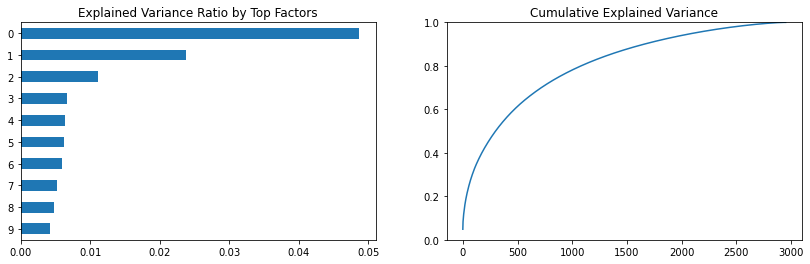

In [18]:
# Dimension reduction
from sklearn.decomposition import PCA
pca = PCA()
PrincipalComponent=pca.fit_transform(tfidf.toarray())

NumEigenvalues=2953
fig, axes = plt.subplots(ncols=2, figsize=(14,4))

pd.Series(pca.explained_variance_ratio_[:10]).sort_values().plot.barh(title='Explained Variance Ratio by Top Factors',ax=axes[0]);
pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).cumsum().plot(ylim=(0,1),ax=axes[1], title='Cumulative Explained Variance');

In [19]:
df_explained_variance=pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame('Explained Variance_Top 2953').head(2953)
df_explained_variance[df_explained_variance['Explained Variance_Top 2953']>=0.60].head(1).index[0]

472

In [20]:
n_components=473
pca = PCA(n_components=n_components, random_state=1)
X_pca = pca.fit_transform(tfidf.toarray())

In [24]:
df = pd.DataFrame()
for i in range(n_components):
    df["pc-%d"%(i+1)] = X_pca[:,i]

In [25]:
df

pc-1      pc-2      pc-3      pc-4      pc-5      pc-6      pc-7  \
0     -0.070204  0.246128 -0.009103 -0.004715  0.008693  0.014314 -0.014569   
1     -0.062165 -0.034653 -0.017818 -0.005939  0.007163  0.014971 -0.009324   
2     -0.058170 -0.035180 -0.010612 -0.006539  0.007342  0.011959 -0.013064   
3     -0.065820  0.080482 -0.014431 -0.000880  0.010692  0.011095 -0.013264   
4     -0.065166  0.078690 -0.012729 -0.002620  0.004699  0.013657 -0.020392   
...         ...       ...       ...       ...       ...       ...       ...   
31568 -0.075544 -0.068175  0.961690  0.021955  0.003378 -0.011516  0.020811   
31569 -0.075544 -0.068175  0.961690  0.021955  0.003378 -0.011516  0.020811   
31570 -0.067832 -0.043946 -0.032660  0.342386  0.069178  0.000667 -0.000815   
31571 -0.059333 -0.036592 -0.012125 -0.007416  0.004641  0.011556 -0.012689   
31572 -0.059121 -0.037073 -0.011959 -0.005394 -0.000524  0.005456  0.001520   

           pc-8      pc-9     pc-10     pc-11     pc-12     pc-13     pc-14  \
0     -0.082332 -0.095629  0.227388 -0.081509 -0.060159  0.090630  0.297304   
1     -0.081532 -0.116171  0.084644 -0.028648  0.027846  0.027085  0.137497   
2     -0.021616 -0.020706 -0.006710  0.004185  0.002993 -0.007591 -0.009664   
3     -0.047673 -0.065342  0.051076 -0.014683  0.004240  0.015718  0.062599   
4     -0.033245 -0.034648  0.043127 -0.006935 -0.016904  0.017007  0.032196   
...         ...       ...       ...       ...       ...       ...       ...   
31568  0.015055  0.007374  0.019646  0.015048 -0.009780 -0.001346  0.007224   
31569  0.015055  0.007374  0.019646  0.015048 -0.009780 -0.001346  0.007224   
31570 -0.010608 -0.024842  0.056320 -0.023099  0.010726  0.019956  0.081774   
31571 -0.026399 -0.019314 -0.009610 -0.003213  0.013733 -0.004725 -0.008540   
31572 -0.029910 -0.029007 -0.005077  0.009984  0.012272 -0.004709 -0.016943   

          pc-15     pc-16     pc-17     pc-18     pc-19     pc-20     pc-21  \
0     -0.171728  0.080643  0.081613  0.030275 -0.072576  0.117694  0.041110   
1     -0.244257 -0.037395  0.040450 -0.111926 -0.282360  0.618164  0.029437   
2     -0.016306 -0.010886 -0.008488 -0.006496 -0.002932 -0.008145 -0.006288   
3     -0.097794 -0.011403  0.005319 -0.041138 -0.091808  0.153618  0.032556   
4     -0.029743  0.003181 -0.006113 -0.005203 -0.004767 -0.012093 -0.005829   
...         ...       ...       ...       ...       ...       ...       ...   
31568  0.010961  0.006878 -0.003905  0.003608  0.002200  0.007403  0.003015   
31569  0.010961  0.006878 -0.003905  0.003608  0.002200  0.007403  0.003015   
31570 -0.127924 -0.010731  0.033335 -0.060319 -0.158729  0.363858  0.009672   
31571 -0.023587 -0.018034 -0.013027 -0.010461 -0.008689 -0.006566 -0.014506   
31572 -0.018220 -0.017594 -0.016071 -0.011921 -0.009023 -0.012016 -0.020700   

          pc-22     pc-23     pc-24     pc-25     pc-26     pc-27     pc-28  \
0     -0.164154 -0.169262  0.293191  0.015233 -0.006844 -0.019642 -0.003272   
1      0.264427  0.422739 -0.364328 -0.006459 -0.002941  0.015346 -0.035347   
2      0.001701 -0.005388  0.001089 -0.010923 -0.007841 -0.001658  0.005316   
3      0.048809  0.078979 -0.102902  0.052665  0.040651  0.003796 -0.005440   
4     -0.009021 -0.015199  0.020122  0.002410 -0.012606 -0.007838 -0.005821   
...         ...       ...       ...       ...       ...       ...       ...   
31568  0.002947 -0.001912 -0.003948  0.015007 -0.010757 -0.002278 -0.000409   
31569  0.002947 -0.001912 -0.003948  0.015007 -0.010757 -0.002278 -0.000409   
31570  0.158386  0.263710 -0.197151 -0.011169 -0.008621  0.012360 -0.026457   
31571 -0.005441 -0.013115 -0.003603 -0.007024  0.003603 -0.002729  0.001285   
31572 -0.004045 -0.020507 -0.006914 -0.003307  0.003965  0.005032  0.003674   

          pc-29     pc-30     pc-31     pc-32     pc-33     pc-34     pc-35  \
0      0.005949 -0.000990  0.004597  0.011713  0.001091  0.006133  0.000131   
1     -0.003973  0.013287  0.016875 -0.009015  0.001687  

In [40]:
total_pca=pd.concat([df_key,df],axis=1)
total_pca.to_csv('keywords_tfidf_PCA')
total_pca


id                                           keywords  \
0       16612                                 dancer silent film   
1       88013                                              short   
2       16624                            blacksmith beer workmen   
3         774  factory worker factory lyon closing time film ...   
4         160  france train station cinema beginning film and...   
...       ...                                                ...   
31568  461634                                    stand-up comedy   
31569  462108                                    stand-up comedy   
31570  463800                                  vietnam war short   
31571  464207                      nature science canadian movie   
31572  460135                                     superhero lego   

       averageRating                                          clean_key  \
0                5.6                                 dancer silent film   
1                6.5                                              short   
2                6.1                            blacksmith beer workman   
3                6.9  factory worker factory lyon closing time film ...   
4                7.4  france train station cinema begin film cinema ...   
...              ...                                                ...   
31568            6.8                                       stand comedy   
31569            6.5                                       stand comedy   
31570            7.2                                  vietnam war short   
31571            6.7                       nature science canadian movi   
31572            5.2                                     superhero lego   

           pc-1      pc-2      pc-3      pc-4      pc-5      pc-6      pc-7  \
0     -0.070204  0.246128 -0.009103 -0.004715  0.008693  0.014314 -0.014569   
1     -0.062165 -0.034653 -0.017818 -0.005939  0.007163  0.014971 -0.009324   
2     -0.058170 -0.035180 -0.010612 -0.006539  0.007342  0.011959 -0.013064   
3     -0.065820  0.080482 -0.014431 -0.000880  0.010692  0.011095 -0.013264   
4     -0.065166  0.078690 -0.012729 -0.002620  0.004699  0.013657 -0.020392   
...         ...       ...       ...       ...       ...       ...       ...   
31568 -0.075544 -0.068175  0.961690  0.021955  0.003378 -0.011516  0.020811   
31569 -0.075544 -0.068175  0.961690  0.021955  0.003378 -0.011516  0.020811   
31570 -0.067832 -0.043946 -0.032660  0.342386  0.069178  0.000667 -0.000815   
31571 -0.059333 -0.036592 -0.012125 -0.007416  0.004641  0.011556 -0.012689   
31572 -0.059121 -0.037073 -0.011959 -0.005394 -0.000524  0.005456  0.001520   

           pc-8      pc-9     pc-10     pc-11     pc-12     pc-13     pc-14  \
0     -0.082332 -0.095629  0.227388 -0.081509 -0.060159  0.090630  0.297304   
1     -0.081532 -0.116171  0.084644 -0.028648  0.027846  0.027085  0.137497   
2     -0.021616 -0.020706 -0.006710  0.004185  0.002993 -0.007591 -0.009664   
3     -0.047673 -0.065342  0.051076 -0.014683  0.004240  0.015718  0.062599   
4     -0.033245 -0.034648  0.043127 -0.006935 -0.016904  0.017007  0.032196   
...         ...       ...       ...       ...       ...       ...       ...   
31568  0.015055  0.007374  0.019646  0.015048 -0.009780 -0.001346  0.007224   
31569  0.015055  0.007374  0.019646  0.015048 -0.009780 -0.001346  0.007224   
31570 -0.010608 -0.024842  0.056320 -0.023099  0.010726  0.019956  0.081774   
31571 -0.026399 -0.019314 -0.009610 -0.003213  0.013733 -0.004725 -0.008540   
31572 -0.029910 -0.029007 -0.005077  0.009984  0.012272 -0.004709 -0.016943   

          pc-15     pc-16     pc-17     pc-18     pc-19     pc-20     pc-21  \
0     -0.171728  0.080643  0.081613  0.030275 -0.072576  0.117694  0.041110   
1     -0.244257 -0.037395  0.040450 -0.111926 -0.282360  0.618164  0.029437   
2     -0.016306 -0.010886 -0.008488 -0.006496 -0.002932 -0.008145 -0.006288   
3     -0.097794 -0.011403  0.005319 -0.041138 -0.091808  0.153618  0.032556   


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

x_train,x_test,y_train,y_test=train_test_split(df,labels,test_size=0.3)
lr_clf = LogisticRegression(max_iter=20000)
lr_clf.fit(x_train, y_train)

#validate the model
lr_clf.score(x_test, y_test)

0.6412286257124763